<a href="https://colab.research.google.com/github/CorentinMAG/CV/blob/main/ML4CV_handson_01_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning For Computer Vision**
# **Hands-on sessions**

# Session 1: A brief how-to on training Deep Neural Networks for Classification.

In this sessions, we will learn how to:

- Create a Convolutional Neural Network from scratch.
- Modify an off the shelf architecture.
- Navigate through the bias and variance path.
- Perform visual debug with [Tensorboard](https://www.tensorflow.org/tensorboard/).

Prerequisites:

- [Python](https://www.python.org/)
- [Pytorch](https://pytorch.org/)

Contacts:

- Riccardo Spezialetti (riccardo.spezialetti@unibo.it)
- Samuele Salti  (samuele.salti@unibo.it)

Course:

- Website and notebooks will be available at https://virtuale.unibo.it

# Disclaimer
Training neural networks requires time. To discuss a few aspects in the limited time availble today, we are going to heavily limit the running time of our trainings. At the end of the notebook, you can find some suggestions on further things to try and an additional exercise, that you can work on at home where training with less restrictive time constraints. 

# Import Dependencies

We import here all the libraries we need to execute this hands-on session.

In [ ]:
from __future__ import print_function
from __future__ import division

import math
import random
import torch
import torchvision
import torch.nn as nn
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from torch import nn, optim, utils
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union

# Reproducibility
When experimenting with a new Neural Network is desirable to have a deterministic behaviour. For this reason we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

**Great [news](https://pytorch.org/docs/master/generated/torch.set_deterministic.html)**: PyTorch 1.7 (released two days ago) adds the `torch.set_deterministic(bool) `function that allows PyTorch to select deterministic algorithms and throws a runtime error if an operation may result in nondeterministic behavior.





In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    # Add comment for each random seed
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
fix_random(seed=42)

# Runtime Settings

Let's check that our  environment has the proper configuration.

In [ ]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


If no GPU is available, you should change the Runtime settings. ![nll](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/uc14.png)

The GPUs available in Colab include Nvidia K80s, T4s, P4s and P100s, but they can vary over time. Unfortuately, there is no way to choose the type of GPU you will connect to in Colab at any given time. If you want to change it, try a `Factory reset runtime` to see if a new type of GPUs is assigned to you.



In [ ]:
!nvidia-smi

Fri Oct 30 12:24:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get the Data
In this session we will use the Tiny ImageNet [dataset](https://https://tiny-imagenet.herokuapp.com/) that is a subset of ImageNet. Tiny Imagenet has 200 classes. Each class has 500 training images, 50 validation images, and 50 test images. All the images have a resolution of 64 x 64. We will use only the training and validation images.

## Download the Tiny ImageNet dataset

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2020-10-30 12:24:35--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  18.0MB/s    in 16s     

2020-10-30 12:24:51 (14.6 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
!unzip -qq tiny-imagenet-200.zip

In [ ]:
!ls tiny-imagenet-200/

test  train  val  wnids.txt  words.txt


To load the data with PyTorch we can use the `torchvision.datasets.ImageFolder` component. It is a generic data loader that loads the images as well as the label associated with each sample. However, the images should be arranged in this way:
```
root/category_0/sample_0.png
root/category_0/sample_1.png
root/category_0/sample_2.png

root/category_1/sample_0.png
root/category_1/sample_1.png
root/category_1/sample_3.png
```











Unfortunately this is not our case.

In [ ]:
!ls tiny-imagenet-200/train/n01443537/

images	n01443537_boxes.txt


In [ ]:
!ls tiny-imagenet-200/val/images

val_0.JPEG     val_2800.JPEG  val_4600.JPEG  val_6400.JPEG  val_8200.JPEG
val_1000.JPEG  val_2801.JPEG  val_4601.JPEG  val_6401.JPEG  val_8201.JPEG
val_1001.JPEG  val_2802.JPEG  val_4602.JPEG  val_6402.JPEG  val_8202.JPEG
val_1002.JPEG  val_2803.JPEG  val_4603.JPEG  val_6403.JPEG  val_8203.JPEG
val_1003.JPEG  val_2804.JPEG  val_4604.JPEG  val_6404.JPEG  val_8204.JPEG
val_1004.JPEG  val_2805.JPEG  val_4605.JPEG  val_6405.JPEG  val_8205.JPEG
val_1005.JPEG  val_2806.JPEG  val_4606.JPEG  val_6406.JPEG  val_8206.JPEG
val_1006.JPEG  val_2807.JPEG  val_4607.JPEG  val_6407.JPEG  val_8207.JPEG
val_1007.JPEG  val_2808.JPEG  val_4608.JPEG  val_6408.JPEG  val_8208.JPEG
val_1008.JPEG  val_2809.JPEG  val_4609.JPEG  val_6409.JPEG  val_8209.JPEG
val_1009.JPEG  val_280.JPEG   val_460.JPEG   val_640.JPEG   val_820.JPEG
val_100.JPEG   val_2810.JPEG  val_4610.JPEG  val_6410.JPEG  val_8210.JPEG
val_1010.JPEG  val_2811.JPEG  val_4611.JPEG  val_6411.JPEG  val_8211.JPEG
val_1011.JPEG  val_2812.JPEG  val_4612.

In [ ]:
import glob
import os
import shutil

from distutils.dir_util import copy_tree
from tqdm.auto import tqdm
from time import sleep

def arrange_train_images(path_data: str) -> int:
    """Moves images from the folder images to the category folder.

    Args:
        path_data: path to the training set.

    Returns:
        the number of moved images.

    Raises:
        FileNotFoundError: if path_data is empty.
    """
    num_moved_images = 0
    try:
        directories = os.listdir(path_data)
    except FileNotFoundError:
        print(f'No directories found in {path_data}')
        raise
        
    for i in tqdm(range(len(directories)), leave=False):        
        path_category = os.path.join(path_data, directories[i])
        path_old_images = os.path.join(path_category, 'images')
        paths = glob.glob(os.path.join(path_old_images, '*'))
        
        for j in tqdm(range(len(paths)), leave=False):
            path_source = paths[j]
            name_file = os.path.basename(path_source)
            path_dest = os.path.join(path_category, name_file)
            shutil.move(path_source, path_dest)            
            num_moved_images += 1

        if os.path.exists(path_old_images):
            os.rmdir(path_old_images)
    return num_moved_images

def split_validation_in_folders(path_data: str) -> int:
    """Splits the validation data set in category folders.

    Args:
        path_data: path to the validation set.

    Returns:
        the number of moved images.

    Raises:
        FileNotFoundError: if val_annotations.txt is not found.
        FileNotFoundError: if validation images are not found.
    """
    num_moved_images = 0
    image_to_label = {}
    path_file_annotation = os.path.join(path_data, 'val_annotations.txt')
    with open(path_file_annotation, 'r') as f:
        for line in f.readlines():
            split_line = line.split('\t')
            image_to_label[split_line[0]] = split_line[1]

    path_val = os.path.join(path_data, 'images')
    paths = glob.glob(os.path.join(path_val, '*'))
    if not paths:
        raise FileNotFoundError(f'No validation images found in {path_val}')

    for path in paths:
        file = path.split(os.sep)[-1]
        folder = image_to_label[file]
        path_folder = os.path.join(path_data, str(folder))
        if not os.path.exists(path_folder):
            os.mkdir(path_folder)

    for i in tqdm(range(len(paths)), leave=False):
        path_source = paths[i]
        file = path_source.split(os.sep)[-1]
        folder = image_to_label[file]
        path_dest = os.path.join(path_data, str(folder), str(file))
        shutil.move(path_source, path_dest)        
        num_moved_images += 1

    os.remove(path_file_annotation)
    os.rmdir(path_val)
    return num_moved_images

In [ ]:
path_dataset = "tiny-imagenet-200/"

arrange_train_images(os.path.join(path_dataset, "train"))

100000

In [ ]:
split_validation_in_folders(os.path.join(path_dataset, "val"))

10000

Due to time constraints we will use only 15 categories.

In [ ]:
def create_sub_set(path_source_dataset: str, path_dest_dataset: str, num_classes: int) -> int:
    """Creates a new copy of the dataset containing only a a subset of classes.

    Args:
        path_source_dataset: the path to the source data set containing all the classes.
        path_dest_dataset: the path to the destination data set.
        num_classes: the number classes for the new dataset.

    Returns:
        the number of copied folder for the train and validation set.

    Raises:
        FileNotFoundError: if path_source_dataset has no sub folders.
    """
    num_copied_dirs = 0
    try:
        categories = os.listdir(os.path.join(path_source_dataset, "train"))[:num_classes]
    except FileNotFoundError:
        print(f'No directories found in {path_source_dataset}')
        raise

    if not os.path.exists(path_dest_dataset):
        os.mkdir(path_dest_dataset)
    
    splits = ["train", "val"]
    for i in tqdm(range(len(splits)), leave=False):
        data_split = splits[i]
        for j in tqdm(range(len(categories)), leave=False):
            category = categories [j]
            os.makedirs(os.path.join(path_dest_dataset, data_split, category))
            copy_tree(os.path.join(path_source_dataset, data_split, category),
                      os.path.join(path_dest_dataset, data_split, category))            
            num_copied_dirs += 1
    return num_copied_dirs

In [ ]:
path_sub_set = "tiny-imagenet-15/"
path_sub_set_train = os.path.join(path_sub_set, "train")
path_sub_set_val = os.path.join(path_sub_set, "val")

if os.path.exists(path_sub_set):
    print(f'The dataset already exists')
else:
    create_sub_set(path_dataset, path_sub_set, 15)

In [ ]:
!ls tiny-imagenet-15/train/

n01855672  n02125311  n02791270  n04008634  n04487081
n01910747  n02268443  n03444034  n04259630  n07753592
n01983481  n02364673  n03838899  n04265275  n12267677


In [ ]:
!ls tiny-imagenet-15/val/

n01855672  n02125311  n02791270  n04008634  n04487081
n01910747  n02268443  n03444034  n04259630  n07753592
n01983481  n02364673  n03838899  n04265275  n12267677


## Create the ```Dataset``` classes
Once the dataset is saved on the local storage we can instantiate the ```Dataset``` classes to handle the images and the labels.

A recommended pre-precossing step when working with deep neural networks is to scale the input data, this step is achieved by normalizing or standardizing the input data.


> ***Good Practice: input data should be standardized with a 0 mean and a standard deviation of 1***.



Since we are working with images with RGB color channels, we normalize each color channel with respect to the mean and standard deviation values calculated across all pixels in every images for the respective color channel.

In [ ]:
def get_mean_and_std(dataset: torchvision.datasets.ImageFolder) -> Tuple[List[float], List[float]]:
    """Compute mean and std for the dataset.

    Args:
        dataset: the dataset. 

    Returns:
        The mean and the std on each channels computed over the dataset.
    """    
    dataset_loader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=512,
                                                 shuffle=False,
                                                 pin_memory=True,
                                                 num_workers=1)
    mean = 0.
    std = 0.
    num_samples = 0.
    for _, (images, labels) in enumerate(dataset_loader):
        num_samples_batch = images.size(0)
        images = images.view(num_samples_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += num_samples_batch

    mean /= num_samples
    std /= num_samples

    return mean, std

In [ ]:
dataset_for_std = torchvision.datasets.ImageFolder(path_dataset, 
                                                   transform=transforms.ToTensor())
mean_image_net, std_image_net = get_mean_and_std(dataset_for_std)

In [ ]:
size_image = 64
normalize = transforms.Normalize(mean_image_net, std_image_net)

transform = transforms.Compose([transforms.ToTensor(), normalize])
    
data_train = torchvision.datasets.ImageFolder(path_sub_set_train, 
                                              transform=transform)
data_val = torchvision.datasets.ImageFolder(path_sub_set_val,
                                            transform=transform)

num_classes = len(data_train.classes)

print(f'Samples -> Train = {len(data_train)} - Val = {len(data_val)} '
      f'- Classes = {num_classes}')

Samples -> Train = 7500 - Val = 750 - Classes = 15


## Visualize your Data
Let's visualize some samples from the training dataset together with the one of the associated word for the category.

In [ ]:
class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [ ]:
def get_ids_to_words(path_file_words: str) -> Dict[str, str]:
    """Reads the corresponding words for the categories ids.

    Args:
        path_file_words: the path the the imagenet file.

    Returns:
        The correspondences between categories ids and words.
    """
    ids_to_words = {}
    with open(path_file_words) as f:
        for line in f:
            values = line.split()
            ids_to_words[values[0]] = values[1].replace(",", "")
    
    return ids_to_words

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              ids_to_word: Dict[str, str], process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
        ids_to_word: ids to words dictionary.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = ids_to_word[dataset.classes[dataset[idx][1]]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

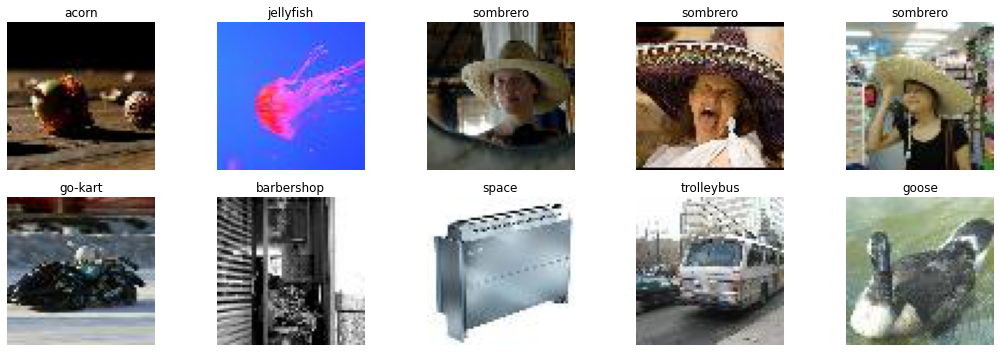

In [ ]:
denormalize = NormalizeInverse(mean_image_net, std_image_net)
ids_to_words = get_ids_to_words("tiny-imagenet-200/words.txt")
show_grid(data_train, ids_to_word=ids_to_words, process=denormalize)

What about the distribution of the samples in each category ? Let's plot the distribution of the samples across the classes in the training and test sets.

In [ ]:
def plot_histograms(dataset_train: torchvision.datasets.ImageFolder,
                    dataset_test: torchvision.datasets.ImageFolder,
                    title: str) -> None:
    """Plot histograms with train and test or validation data distributions.

    Args:
        dataset_train: the train dataset.
        dataset_test: the test or validation dataset.
        title: the title of the plot.
    """
    classes = len(dataset_train.classes)
    bins = np.linspace(0, classes, classes + 1, dtype=np.int)
    plt.title(title)
    plt.hist([dataset_train.targets, dataset_test.targets], bins=bins, 
             label=['Train', 'Test'])
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
plot_histograms(data_train, data_val, "Data Distribution")

> ***Good Practice: visualize some samples and the distributions of training and validation data***.



## Create the `Loaders`

To train the newtork with PyTorch we need `workers`. To speed up the transfer between CPU and GPU we set the attribute `pin_meory=True`. This tell to your `DataLoader` to allocate the samples in page-locked memory and speeds-up the transfer. More information about that are available at this [page](https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/).


In [ ]:
 # Loader
num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(data_train, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, 
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(data_val, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

# Get the Network
Now that we have succesfully created the datasets, we need to focus on how to building the model to train. Thus as a first exercise, you will have to fill the code below to develop a convolutional neural network. 

>Type | Input Channels | Output Channels | Kernel | Padding | Stride
>--- | --- | --- | --- | --- | --- |
>Conv1 | 3 | 4 | 3 | 0  | 3
> BN
> ReLU
>MaxPooling 2D | - | - | 2 | 0  | 2
>Conv2 | 4 | 8 | 3 | 0  | 1
> BN
> ReLU
>MaxPooling 2D | - | - | 2 | 0  | 2
>FC1   | ? | 32 | - |- | -
> BN
> ReLU
>Out   | 32 | 15 | - |- | -



**What is the correct number of input activations for the first fully connected layer ?**

In [ ]:
def get_conv2d_bn_relu(name:str,
                       channels_in: int,
                       channels_out: int,
                       size_kernel: Union[int, tuple],
                       stride: Union[int, tuple],
                       padding: Union[int, tuple]) -> nn.Sequential:
    """Gets a sequential container with a sandwich of 2D Convolution, 
       BatchNorm and Relu.

    Args:
        name: the name prefix to append to each layer in the container.
        channels_in: the number of the input channels.
        channels_out: the number of the output channels.
        size_kernel: the size of the kernel.
        stride: the stride.
        padding: the padding.

    Returns: the created sequential.
    """
    container = nn.Sequential()
    container.add_module(f'{name}_conv_2d', nn.Conv2d(channels_in, channels_out, 
                                                      kernel_size=size_kernel,
                                                      stride=stride, padding=padding))
    container.add_module(f'{name}_batch_norm_2d', nn.BatchNorm2d(channels_out))
    container.add_module(f'{name}_ReLU', nn.ReLU(inplace=True))
    return container

def get_linear_bn_relu(name:str,
                       features_in: int,
                       features_out: int) -> nn.Sequential:
    """Gets a sequential container with a sandwich of Fully connected layer, 
       BatchNorm and Relu.

    Args:
        name: the name prefix to append to each layer in the container.
        features_in: the number of the input features.
        features_out: the number of the output features.

    Returns: the created sequential.
    """
    container = nn.Sequential()
    container.add_module(f'{name}_fc', nn.Linear(in_features=features_in, out_features=features_out))
    container.add_module(f'{name}_batch_norm_1d', nn.BatchNorm1d(features_out))
    container.add_module(f'{name}_ReLU', nn.ReLU(inplace=True))
    return container

Using the functions provided, fill the methods `__init__` and `forward` in the below class.

In [ ]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes: int=10) -> None:
        """Tiny Convolution Neural Network.

        Args:
            num_classes: the number of classes. 
        """
        super().__init__()
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #
        raise NotImplementedError("Fill this part with your code.")        
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #
        

    def forward(self, x):        
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #
        raise NotImplementedError("Fill this part with your code.")   
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #

Use the `torchsummary` package to get an overview of the network and check if it corresponds to the one required.

In [ ]:
# Network
summary(TinyCNN(num_classes=len(data_train.classes)), 
        input_size=(3, size_image, size_image), 
        batch_size=size_batch, device="cpu")

NotImplementedError: ignored

# Train the Network
We will train our network using the Adam optimizer. At the end of each epoch we will check the accuracy of the classifier on the validation set. What is the final accuracy after training for 15 epochs ? 


### Visual Debug with Tensorboard
[Tensorboard](https://www.tensorflow.org/tensorboard/) is a web based tool that provides the visualization and tooling needed to experiment with machine learning, is developed by Google and integrated in [Pytorch](https://pytorch.org/docs/stable/tensorboard.html#). Tensorboard allows you to visualize the training parameters, metrics, hyperparameters or any statistics of your neural network.

In [ ]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

## Train
Here we define all the necessary functions to execute the training loop.

In [ ]:
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Get the number of correctly classified examples.

    Args:
        scores: the probability distribution.
        labels: the class labels.

    Returns: :return: the number of correct samples

    """
    classes_predicted = torch.argmax(scores, 1)
    return (classes_predicted == labels).sum().item()

In [ ]:
def train(writer: torch.utils.tensorboard.writer.SummaryWriter,
          model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float, float]:
    """Train loop to train a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch

    Returns:
        the Cross Entropy Loss value on the training data, 
        the accuracy on the training data.
    """    
    correct = 0
    samples_train = 0
    loss_train = 0
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)

    model.train()
    for idx_batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(images)

        loss = criterion(scores, labels)
        loss_train += loss.item() * len(images)
        samples_train += len(images)        

        loss.backward()
        optimizer.step()
        correct += get_correct_samples(scores, labels)

        if log_interval > 0:
            if idx_batch % log_interval == 0:
                running_loss = loss_train / samples_train
                global_step = idx_batch + (epoch * num_batches) 
                writer.add_scalar('Metrics/Loss_Train_IT', running_loss, global_step)
                
    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

## Validate

In the same way we define the function for the validation phase.


In [ ]:
def validate(model: nn.Module,
             data_loader: utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluate the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data 
        the accuracy on the validation data
    """
    correct = 0
    samples_val = 0
    loss_val = 0.
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            scores = model(images)

            loss = criterion(scores, labels)
            loss_val += loss.item() * len(images)
            samples_val += len(images)
            correct += get_correct_samples(scores, labels)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

## Training Loop
A training loop for a neural network alternates the train and validate steps.

In [ ]:
def training_loop(writer: torch.utils.tensorboard.writer.SummaryWriter,
                  num_epochs: int, 
                  optimizer: torch.optim, 
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True)->Dict:
    """Executes the training loop.
    
        Args:
            name_exp: the name for the experiment.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            log_interval: interval to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: 

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch
            the values for the train accuracy for each epoch
            the values for the validation accuracy for each epoch
            the time of execution in seconds for the entire loop
        """
    criterion = nn.CrossEntropyLoss()    
    loop_start = timer()

    losses_values = []
    train_acc_values = []
    val_acc_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train, accuracy_train = train(writer, model, loader_train, device, 
                                           optimizer, criterion, log_interval, 
                                           epoch)
        loss_val, accuracy_val = validate(model, loader_val, device, criterion)
        time_end = timer()

        losses_values.append(loss_train)
        train_acc_values.append(accuracy_train)
        val_acc_values.append(accuracy_val)
        
        lr =  optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Plot to tensorboard        
        writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
        writer.add_scalars('Metrics/Losses', {"Train": loss_train, "Val": loss_val}, epoch)
        writer.add_scalars('Metrics/Accuracy', {"Train": accuracy_train, "Val": accuracy_val}, epoch)
        writer.flush()
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'loss_values': losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

## Execute the loop for TinyCNN
Now that we have all the code in place, we can start to train.

In [ ]:
def check_cross_entropy_at_init(model: nn.Module, num_classes: int, data: torch.Tensor) -> Tuple[float]:
    """Checks the Cross entropy value at initialization with a simple forward pass of random data

    Args:
        model: the initialized model.
        num_classes: the number of classes.

    Returns:
        The computed value and the true value.

    """
    target = torch.empty(data.size(0), dtype=torch.long).random_(num_classes)

    output = model(data)
    criterion = nn.CrossEntropyLoss()

    return criterion(output, target).item(), math.log(num_classes)

Verify that your loss starts at the correct loss value. In case of correct initialization you should measure `log(num_classes)` on a softmax at initialization. 

In [ ]:
input_batch = torch.rand(size_batch, 3, size_image, size_image)
true, pred = check_cross_entropy_at_init(TinyCNN(num_classes=num_classes), 
                                         num_classes, 
                                         input_batch)
print(f'True Value: {true:.4f} - Actual Value: {pred:.4f}')

Invoke tensoboard before start training.

In [ ]:
 %tensorboard --logdir="logs"

In [ ]:
lr = 0.001
num_epochs = 15
log_interval = 20

tiny_cnn = TinyCNN(num_classes=len(data_train.classes))
tiny_cnn = tiny_cnn.to(device)
optimizer = torch.optim.Adam(tiny_cnn.parameters(), lr=lr)

writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=os.path.join("logs", "tiny_cnn"))
statistics = training_loop(writer, num_epochs, optimizer, log_interval, tiny_cnn, loader_train, loader_val)
writer.close()

best_epoch = np.argmax(statistics['val_acc_values']) + 1
best_accuracy = statistics['val_acc_values'][best_epoch - 1]

print(f'Best val accuracy: {best_accuracy:.2f} epoch: {best_epoch}.')

The gap between train and validation accuracy it's not that big and the traning error is high. This means **underfitting**. 

Follow the path to low bias and low variance...


Possibile solutions: 
*   Train longer, unfortunately we can't.
*   Use a bigger network.
*   Better architecture.

# Can we do better ?
The results with `TinyCNN` are unsatisfactory. We are in a low variance and low bias configuration. 

> ***Good Practice: Leverage high capacity models to reach low bias and then try to reduce their variance.***

## Capacity
You have studied different architectures in class. Which one can be worth trying in our case in your opinion ?







* [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

![mobilenet_arch](https://pytorch.org/assets/images/mobilenet_v2_2.png)

In order to use MobileNetV2 with our dataset we have to apply some modifications to the architecture to handle the lower resolution of the data.
We can navigate into the [code](https://github.com/pytorch/vision/blob/master/torchvision/models/mobilenet.py) to see how the model is implemented.

The final configuration that we want to use for the feature extraction is reported in the following table:
>Operator | t | c | n | s
>--- | --- | --- | --- | --- |
>bottleneck | 1 | 16 | 1 | 1
>bottleneck | 6 | 24 | 1 | 1
>bottleneck | 6 | 32 | 1 | 1
>bottleneck | 6 | 64 | 1 | 2
>bottleneck | 6 | 96 | 1 | 2
>bottleneck | 6 | 160 | 1 | 2
>bottleneck | 6 | 320 | 1 | 2

The final classifier will be a simple fully connected layer:

>Operator | Input Channels | Output Channels
>--- | --- | --- | 
>FC | 1280 | 15
                
                
                
                
                
                


Modify the code below, to produce a `TinyMobileNet` .

In [ ]:
class TinyMobileNet(nn.Module):
    def __init__(self, num_classes: int =10) -> None:
        """Tiny Mobile Net.

        Args:
            num_classes: the number of classes. 
        """
        super().__init__()
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #
        self.features = None
        self.features[0][0].stride = (1, 1)
        self.classifier = None        
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #                    
    
    def forward(self, x):
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #        
        raise NotImplementedError("Fill this part with your code.")
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== # 

In [ ]:
summary(TinyMobileNet(num_classes=num_classes),
        input_size=(3, size_image, size_image), batch_size=size_batch, device="cpu")

In [ ]:
input_batch = torch.rand(size_batch, 3, size_image, size_image)
true, pred = check_cross_entropy_at_init(TinyMobileNet(num_classes=num_classes), 
                                         num_classes,
                                         input_batch)
print(f'True Value: {true:.4f} - Actual Value: {pred:.4f}')

Let's go through the [paper](https://arxiv.org/pdf/1801.04381.pdf) to search for the correct values to use.

In [ ]:
%tensorboard --logdir="logs/tiny_mn"

In [ ]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
# From the paper 
lr = None
weight_decay = None
momentum = None
tiny_mobile = None
optimizer = None
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

num_epochs = 5
log_interval = 10
path_summary = os.path.join("logs", "tiny_mn", "exp_1")
writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=path_summary)
statistics = training_loop(writer, num_epochs, optimizer, log_interval, 
                           tiny_mobile, loader_train, loader_val, True)
writer.close()

best_epoch = np.argmax(statistics['val_acc_values']) + 1
best_acc_val = statistics['val_acc_values'][best_epoch - 1]

print(f'Best val accuracy: {best_acc_val:.3f} epoch: {best_epoch}.')

It seems that using the same parameters we found in the paper does not give us good results. To improve from here, let's follow the good practices explained during class.


> ***Good Practice: Find a learning rate that makes loss go down in few epochs.***


## Starting Learning Rate
One of the most critical parameters to choose during the optimization process is the **learning rate**. Indeed, all the popular optimizers such as SGD, SGD+ Momentum, Adagrad, RMSProp, Adam have learning rate as a hyperparameter.



In [ ]:
%tensorboard --logdir="logs/lr"

In [ ]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
learning_rates = None
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

# Turn off weight_decay
weight_decay = 0.0
momentum = 0.9
loop_start = timer()
num_epochs = 1
accs_train = {}
accs_val = {}

log_interval = 10
for idx, lr_i in enumerate(learning_rates):
    # For each run get a new network and a new optimizer
    net_lr = TinyMobileNet(num_classes=len(data_train.classes))
    net_lr = net_lr.to(device)
    
    path_summary = os.path.join('logs', 'lr', f'lr_{lr_i:.6f}')
    writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=path_summary)
    
    optimizer = torch.optim.RMSprop(net_lr.parameters(), lr=lr_i, 
                                    weight_decay=weight_decay, 
                                    momentum=momentum)

    statistics = training_loop(writer, num_epochs, optimizer, log_interval, 
                               net_lr, loader_train, loader_val, False)
    
    idx_max_acc_val = np.argmax(statistics['val_acc_values'])
    accuracy_train = statistics['train_acc_values'][idx_max_acc_val]
    accuracy_val = statistics['val_acc_values'][idx_max_acc_val]
        
    accs_train[idx] = accuracy_train
    accs_val[idx] = accuracy_val

    print(f'Lr: {lr_i:.7f} '
          f' Accuracy: Train = [{accuracy_train:.0f}%] '
          f'- Val = [{accuracy_val:.0f}%]')
    
    writer.close()

idx_best_lr = max(accs_val, key=accs_val.get)
value_best_lr = learning_rates[idx_best_lr]
print(f'Best lr: {value_best_lr} '
      f'Best Validation Accuracy: {accs_val[idx_best_lr]:.4f}')
loop_end = timer()
print(f'Time for tuning: {(loop_end - loop_start):.4f} (s).')

Now learning rate is fine. Let's train our network.

In [ ]:
network = TinyMobileNet(num_classes=num_classes)
network = network.to(device)

num_epochs = 15
weight_decay = 0.0
momentum = 0.9
optimizer = torch.optim.RMSprop(network.parameters(), lr=value_best_lr, 
                                weight_decay=weight_decay,
                                momentum=momentum)

log_interval = 10
path_summary = os.path.join("logs", "tiny_mn", "exp_2")
writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=path_summary)

statistics = training_loop(writer, num_epochs, optimizer, log_interval, network,
                           loader_train, loader_val, True)

best_epoch = np.argmax(statistics['val_acc_values']) + 1
best_accuracy = statistics['val_acc_values'][best_epoch - 1]

print(f'Best val accuracy: {best_accuracy:.3f} epoch: {best_epoch}.')

Good, we have achieved what we wanted: low bias, but, unfortunately, high variance.

## Regularization

Regularization is any modification we make to a learning algorithm that is intended to reduce its generalization (test) error but not its training error.
We will see three different forms of regularization:


*   L2 Regularization or weight decay.
*   Dropout.
*   Data Augmentation.



### Weight decay
One of the first methods we should try when we need to reduce overfitting is L2 regularisation. L2 regularization is also known as weight decay as it forces the weights to decay towards zero (but not exactly zero).

In [ ]:
%tensorboard --logdir="logs/wd"

In [ ]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
regularizers = None
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #
momentum = 0.9
loop_start = timer()
num_epochs = 10
accs_train = {}
accs_val = {}
log_interval = 12

for idx, wd_i in enumerate(regularizers):    
    net_reg = TinyMobileNet(num_classes=len(data_train.classes))
    net_reg = net_reg.to(device)
      
    optimizer = torch.optim.RMSprop(net_reg.parameters(), lr=value_best_lr, 
                                    weight_decay=wd_i, 
                                    momentum=momentum)
    
    path_summary = os.path.join('logs', 'wd', f'wd_{wd_i:.6f}')
    writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=path_summary)

    statistics = training_loop(writer, num_epochs, optimizer, log_interval, 
                               net_reg, loader_train, loader_val, False)
    
    idx_max_acc_val = np.argmax(statistics['val_acc_values'])
    accuracy_train = statistics['train_acc_values'][idx_max_acc_val]
    accuracy_val = statistics['val_acc_values'][idx_max_acc_val]
        
    accs_train[idx] = accuracy_train
    accs_val[idx] = accuracy_val

    print(f'WD: {wd_i:.6f} '
          f' Accuracy: Train = [{accuracy_train:.0f}%] '
          f'- Val = [{accuracy_val:.0f}%]')

idx_best_wd = max(accs_val, key=accs_val.get)
value_best_wd = regularizers[idx_best_wd]
print(f'Best WD: {value_best_wd:.6f} '
      f'Best Validation Accuracy: {accs_val[idx_best_wd]:.4f}')
loop_end = timer()
print(f'Time for tuning: {(loop_end - loop_start):.4f} (s).')

TypeError: ignored

### Dropout
Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel by randomly dropping nodes. By using dropout, at each training step we randomly shut down some fraction of neurons in a layer by zeroing out neuron values. 
The fraction of neurons to be zeroed out is known as the dropout rate, $p$. 
Use can use [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) API to modify the `TinyMobileNet` in order to add dropout between the convolutions and the fully connected layer.

In [ ]:
class TinyMobileNetOneDrop(nn.Module):
    def __init__(self, rate_dropout: float, num_classes: int=10) -> None:
        """Tiny Mobile Net with drop out.

        Args:
            rate_dropout: the rate for the drop out.
            num_classes: the number of classes.             
        """
        super().__init__()
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #
        self.features = None
        self.features[0][0].stride = (1, 1)
        self.classifier = None
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #
                                
    def forward(self, x):
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #        
        raise NotImplementedError("Fill this part with your code.")
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== # 
        

In [ ]:
net_one_drop = TinyMobileNetOneDrop(rate_dropout=1.0, 
                                    num_classes=len(data_train.classes))
net_one_drop = net_one_drop.to(device)
summary(net_one_drop, input_size=(3, size_image, size_image), 
        batch_size=size_batch)

In [ ]:
%tensorboard --logdir="logs/drop"

In [ ]:
loop_start = timer()
dropping_prob = [0.0, 0.2, 0.5, 0.8]
num_epochs = 10
accs_train = {}
accs_val = {}
log_interval = 12

for idx, dp_i in enumerate(dropping_prob):    
    # For each run get a new network
    net_with_drop = TinyMobileNetOneDrop(rate_dropout=dp_i,
                                         num_classes=num_classes)
    net_with_drop = net_with_drop.to(device)

    optimizer = torch.optim.RMSprop(net_with_drop.parameters(), 
                                    lr=value_best_lr, 
                                    weight_decay=value_best_wd,
                                    momentum=momentum)
        
    path_summary = os.path.join('logs', 'drop', f'dp_{dp_i:.2f}')
    writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=path_summary)

    statistics = training_loop(writer, num_epochs, optimizer, log_interval, 
                               net_with_drop, loader_train, loader_val, False)
        
    idx_max_acc_val = np.argmax(statistics['val_acc_values'])
    accuracy_train = statistics['train_acc_values'][idx_max_acc_val]
    accuracy_val = statistics['val_acc_values'][idx_max_acc_val]
        
    accs_train[idx] = accuracy_train
    accs_val[idx] = accuracy_val

    print(f'Drop probs {dp_i} '
          f' Accuracy: Train = [{accuracy_train:.0f}%] '
          f'- Val = [{accuracy_val:.0f}%]')

idx_best_drop = max(accs_val, key=accs_val.get)
value_best_drop = dropping_prob[idx_best_drop]
print(f'Best drop: {value_best_drop} '
      f'Best Val Accuracy: {accs_val[idx_best_drop]:.0f}')
loop_end = timer()
print(f'Time for tuning: {(loop_end - loop_start):.3f}')

### Data Augmentation
Finally as last techinque, we are going to perform data augmentation by adding transformations to the data fetching pipeline behind Dataset/Dataloaders, using the function provided in [PyTorch](https://pytorch.org/docs/stable/torchvision/transforms.html):
* `RandomHorizontalFlip`: Random horizontal flip of the image with a given proability.
* `RandomRotation`: Random Rotation of the image by angle.
* `RandomAffine`: Random affine transformation of the image.
* `ColorJitter`: Change the brightness, contrast and saturation of an image in a random way.



In [ ]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
transform_train = None
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

data_train_aug = torchvision.datasets.ImageFolder(path_sub_set_train,
                                                  transform=transform_train)

loader_train_aug = torch.utils.data.DataLoader(data_train_aug, 
                                               batch_size=size_batch, 
                                               shuffle=True, 
                                               pin_memory=True, 
                                               num_workers=num_workers)

show_grid(data_train_aug, ids_to_word=ids_to_words, process=denormalize)

In [ ]:
log_interval = 12
num_epochs = 15
network_best = TinyMobileNetOneDrop(rate_dropout=value_best_drop, 
                                    num_classes=num_classes)
network_best = network.to(device)

optimizer = torch.optim.RMSprop(network_best.parameters(), 
                                lr=value_best_lr, 
                                weight_decay=value_best_wd,
                                momentum=momentum)

path_summary = os.path.join('logs', 'tiny_mn', 'exp_3')
writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir=path_summary)
statistics = training_loop(writer, num_epochs, optimizer, log_interval, 
                           network_best, loader_train_aug, loader_val, True)
writer.close()

best_epoch = np.argmax(statistics['val_acc_values']) + 1
best_accuracy = statistics['val_acc_values'][best_epoch - 1]

print(f'Best val accuracy: {best_accuracy:.3f} epoch: {best_epoch}.')

# Try This at Home 




In order to improve your test accuracy you can complete the following assignments:

*   Train for more than 15 epochs and repeat the flow seen above.
*   Try as another baseline [Wide ResNet](https://pytorch.org/hub/pytorch_vision_wide_resnet/).
*   Perform a hyperparameter sweep by using random search
*   Implement the CutOut data augmentation techniques.
*   Try LR schedules and test time ensembles.



In [ ]:
class CutOut(object):
    def __init__(self, size_square: float) -> None:
        """Cuts out some portion of the image putting squares to mask pixels.

        Args:            
            size_square: the size of the square.
        """        
        self.size_square = size_square

    def __call__(self, image):                
        # ==================================================================== #
        #                         YOUR CODE STARTS HERE                        #
        # ==================================================================== #        
        raise NotImplementedError("Fill this part with your code.")
        # ==================================================================== #
        #                         YOUR CODE ENDS HERE                          #
        # ==================================================================== #        

## Imagewoof Dataset
As a further exercixe at home, try to reach a high score in the [Imagewoof Leaderboard](https://github.com/fastai/imagenette). This dataset is a small vision dataset created to quickly experiment with Convolutional Neural Networks in an ImageNet setting. The dataset is called **Imagewoof** and was created by [FastAI](https://www.fast.ai/). It contains a subset of 10 classes from Imagenet that are all dog breeds such as: Australian terrier, Border terrier, and so on. The dataset is available at different resolutions and we are going to use the 320 px version.

Let's download the dataset from the public repository:

In [ ]:
!wget -P imagewoof https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz

--2020-10-30 12:18:39--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.17.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.17.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92560471 (88M) [application/x-tar]
Saving to: ‘imagewoof/imagewoof2-160.tgz’

imagewoof2-160.tgz  100%[===================>]  88.27M  25.2MB/s    in 3.7s    

2020-10-30 12:18:44 (24.1 MB/s) - ‘imagewoof/imagewoof2-160.tgz’ saved [92560471/92560471]



We now have the tar, let's extract the folders:

In [ ]:
!tar xzf imagewoof/imagewoof2-160.tgz -C imagewoof/

In [ ]:
!ls imagewoof/imagewoof2-160/train

n02086240  n02088364  n02093754  n02099601  n02111889
n02087394  n02089973  n02096294  n02105641  n02115641


In [ ]:
!ls imagewoof/imagewoof2-160/val/

n02086240  n02088364  n02093754  n02099601  n02111889
n02087394  n02089973  n02096294  n02105641  n02115641


In [ ]:
ids_to_categories = {"n02086240": "Shih-Tzu", 
                     "n02087394": "Rhodesian_ridgeback",
                     "n02088364": "beagle",
                     "n02089973": "English_foxhound",
                     "n02093754": "Border_terrier",
                     "n02096294": "Australian_terrier",
                     "n02099601": "golden_retriever",
                     "n02105641": "Old_English_sheepdog",
                     "n02111889": "Samoyed",
                     "n02115641": "dingo"}

We will use some PyTorch utilities to manage the downloaded dataset.

In [ ]:
dir_train = "imagewoof/imagewoof2-160/train/"
dir_val = "imagewoof/imagewoof2-160/val/"
size_image = 320

# The normalization values are precalculated for the Imagenet dataset
mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean_image_net, std_image_net)

data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(size_image),                                 
                                 transforms.ToTensor()])}

dataset_train = datasets.ImageFolder(root=dir_train, 
                                     transform=data_transforms['train'])

dataset_val = datasets.ImageFolder(root=dir_val,
                                   transform=data_transforms['train'])


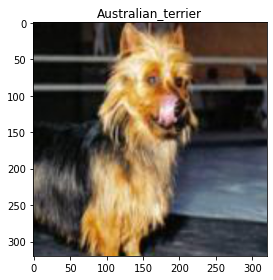

In [ ]:
# @title Dataset examples { run: "auto" }

index_sample = 4783  #@param {type:"slider", min:0, max:9025, step:1}
image, label = dataset_train[index_sample]
category = ids_to_categories[dataset_train.classes[label]]

plt.imshow(transforms.ToPILImage()(image))
plt.title(category)
plt.tight_layout()
plt.show()

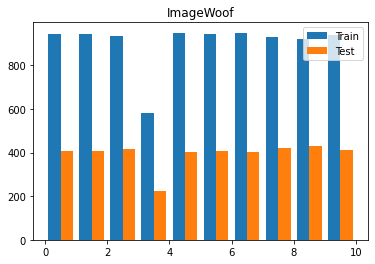

In [ ]:
plot_histograms(dataset_train, dataset_val, "ImageWoof")